# 6. Using a neural network to fit the data
This chapter covers
* Nonlinear activation functions as the key difference compared with linear models
* Working with PyTorch’s `nn` module
* Solving a linear-fit problem with a neural network

In this chapter, we will make some changes to our model architecture: we’re going to
implement a full artificial neural network to solve our temperature-conversion
problem. We’ll continue using our training loop from the last chapter, along with our
Fahrenheit-to-Celsius samples split into training and validation sets. We could start to
use a quadratic model: rewriting `model` as a quadratic function of its input (for
example, $y = a * x**2 + b * x + c$). Since such a model would be differentiable,
PyTorch would take care of computing gradients, and the training loop would work as
usual. That wouldn’t be too interesting for us, though, because we would still be fixing
the shape of the function.

This is the chapter where we begin to hook together the foundational work we’ve
put in and the PyTorch features you’ll be using day in and day out as you work on your
projects. You’ll gain an understanding of what’s going on underneath the porcelain of
the PyTorch API, rather than it just being so much black magic. Before we get into the
implementation of our new model, though, let’s cover what we mean by *artificial neural network*.

![](images/6.1.png)
Figure 6.1 Our mental model of the learning process, as implemented in chapter 5

## 6.1 Artificial neurons
At the core of deep learning are **neural networks**: mathematical entities capable of representing complicated functions through a composition of simpler functions. The term neural network is obviously suggestive of a link to the way our brain works. As a matter of fact, although the initial models were inspired by neuroscience,1 modern artificial neural networks bear only a slight resemblance to the mechanisms of neurons in the brain. It seems likely that both artificial and physiological neural networks use vaguely similar mathematical strategies for approximating complicated functions because that family of strategies works very effectively.

The basic building block of these complicated functions is the neuron, as illustrated in figure 6.2. At its core, it is nothing but a linear transformation of the input (for example, multiplying the input by a number [the weight] and adding a constant [the bias]) followed by the application of a fixed nonlinear function (referred to as the activation function).

Mathematically, we can write this out as $o = f(w * x + b)$, with $x$ as our input, $w$ our weight or scaling factor, and $b$ as our bias or offset. $f$ is our activation function, set to the hyperbolic tangent, or `tanh` function here. In general, $x$ and, hence, o can be simple scalars, or vector-valued (meaning holding many scalar values); and similarly, $w$ can be a single scalar or matrix, while $b$ is a scalar or vector (the dimensionality of the
inputs and weights must match, however). In the latter case, the previous expression is referred to as a `layer` of neurons, since it represents many neurons via the multidimensional weights and biases.

![](images/6.2.png)

### 6.1.1 Composing a multilayer network
A multilayer neural network, as represented in figure 6.3, is made up of a composition
of functions like those we just discussed
```
x_1 = f(w_0 * x + b_0)
x_2 = f(w_1 * x_1 + b_1)
...
y = f(w_n * x_n + b_n)
```
where the output of a layer of neurons is used as an input for the following layer.
Remember that `w_0` here is a matrix, and `x` is a vector! Using a vector allows `w_0` to hold an entire layer of neurons, not just a single weight.

![](images/6.3.png)

### 6.1.2 Understanding the error function
An important difference between our earlier linear model and what we’ll actually be using for deep learning is the shape of the error function. Our linear model and *error-squared loss function* had a *convex error curve* with a singular, clearly defined minimum. If we were to use other methods, we could solve for the parameters minimizing the error function automatically and definitively. That means that our parameter updates were attempting to *estimate* that singular correct answer as best they could.

Neural networks do not have that same property of a convex error surface, even when using the same error-squared loss function! There’s no single right answer for each parameter we’re attempting to approximate. Instead, we are trying to get all of the parameters, when acting **in concert**, to produce a useful output. Since that useful output is only going to **approximate** the truth, there will be some level of imperfection. Where and how imperfections manifest is somewhat arbitrary, and by implication the
parameters that control the output (and, hence, the imperfections) are somewhat arbitrary as well. This results in neural network training looking very much like parameter estimation from a mechanical perspective, but we must remember that the theoretical underpinnings are quite different.

A big part of the reason neural networks have non-convex error surfaces is due to the activation function. The ability of an ensemble of neurons to approximate a very wide range of useful functions depends on the combination of the linear and nonlinear behavior inherent to each neuron.

### 6.1.3 All we need is activation
The activation function plays two important roles:
* In the inner parts of the model, it allows the output function to have different slopes at different values—something a linear function by definition cannot do. By trickily composing these differently sloped parts for many outputs, neural networks can approximate arbitrary functions, as we will see in section 6.1.6
* At the last layer of the network, it has the role of concentrating the outputs of the preceding linear operation into a given range.

Let’s talk about what the second point means. Pretend that we’re assigning a “good doggo” score to images. Pictures of retrievers and spaniels should have a high score, while images of airplanes and garbage trucks should have a low score. Bear pictures should have a lowish score, too, although higher than garbage trucks.

**CAPPING THE OUTPUT RANGE**

We want to firmly constrain the output of our linear operation to a specific range so that the consumer of this output doesn’t have to handle numerical inputs of puppies at 12/10, bears at –10, and garbage trucks at –1,000.
One possibility is to just cap the output values: anything below 0 is set to 0, and anything
above 10 is set to 10. That’s a simple activation function called [`torch.nn.Hardtanh`](https://pytorch.org/docs/stable/nn.html#hardtanh), but note that the default range is –1 to +1.

**COMPRESSING THE OUTPUT RANGE**
Another family of functions that work well is `torch.nn.Sigmoid`, which includes `1 / (1 + e ** -x)`, `torch.tanh`, and others that we’ll see in a moment. These functions have a curve that asymptotically approaches 0 or –1 as x goes to negative infinity, approaches 1 as x increases, and have a mostly constant slope at x == 0. Conceptually, functions shaped this way work well because there’s an area in the middle of our linear function’s output that our neuron (which, again, is just a linear function followed by an activation) will be sensitive to, while everything else gets lumped next to the boundary values. As we can see in figure 6.4, our garbage truck gets a score of –0.97, while bears and foxes and wolves end up somewhere in the –0.3 to 0.3 range.

![](images/6.4.png)
Figure 6.4 Dogs, bears, and garbage trucks being mapped to how dog-like they are via the tanh activation function

In [1]:
import math
math.tanh(-2.2)

-0.9757431300314515

In [2]:
math.tanh(0.1)

0.09966799462495582

In [3]:
math.tanh(2.5)

0.9866142981514303

With the bear in the sensitive range, small changes to the bear will result in a noticeable
change to the result.

### 6.1.4 More activation functions
There are quite a few activation functions, some of which are shown in figure 6.5. In the first column, we see the smooth functions `Tanh` and `Softplus`, while the second column has “hard” versions of the activation functions to their left: `Hardtanh` and `ReLU`. `ReLU` (for *rectified linear unit*) deserves special note, as it is currently considered one of the best-performing general activation functions; many state-of-the-art results
have used it.

![](images/6.5.png)
Figure 6.5 A collection of common and not-so-common activation functions

### 6.1.5 Choosing the best activation function
Without these characteristics, the network either falls back to being a linear model or becomes difficult to train.

The following are true for the functions:
* They have at least one sensitive range, where nontrivial changes to the input result in a corresponding nontrivial change to the output. This is needed for training.
* Many of them have an insensitive (or saturated) range, where changes to the input result in little or no change to the output.

The activation function will have at least one of these:
* A lower bound that is approached (or met) as the input goes to negative infinity
* A similar-but-inverse upper bound for positive infinity

Thinking of what we know about how backpropagation works, we can figure out that the errors will propagate backward through the activation more effectively when the inputs are in the response range, while errors will not greatly affect neurons for which the input is saturated (since the gradient will be close to zero, due to the flat area around the output).

Put together, all this results in a pretty powerful mechanism: we’re saying that in a network built out of linear + activation units, when different inputs are presented to the network, (a) different units will respond in different ranges for the same inputs, and (b) the errors associated with those inputs will primarily affect the neurons operating in the sensitive range, leaving other units more or less unaffected by the learning process. In addition, thanks to the fact that derivatives of the activation with respect to its inputs are often close to 1 in the sensitive range, estimating the parameters of the linear transformation through gradient descent for the units that operate in that range will look a lot like the linear fit we have seen previously.

### 6.1.6 What learning means for a neural network
With a deep neural network model, we have a universal
approximator and a method to estimate its parameters. This approximator can be customized
to our needs, in terms of model capacity and its ability to model complicated
input/output relationships, just by composing simple building blocks. We can see
some examples of this in figure 6.6.

![](images/6.6.png)

Figure 6.6 Composing multiple linear units and tanh activation functions to produce nonlinear outputs

The four upper-left graphs show four neurons—A, B, C, and D—each with its own
(arbitrarily chosen) weight and bias. Each neuron uses the `Tanh` activation function with a min of –1 and a max of 1. The varied weights and biases move the center point and change how drastically the transition from min to max happens, but they clearly all have the same general shape. The columns to the right of those show both pairs of neurons added together (A + B and then C + D). Here, we start to see some interesting properties that mimic a single layer of neurons. A + B shows a slight S curve, with the extremes approaching 0, but both a positive bump and a negative bump in the middle. Conversely, C + D has only a large positive bump, which peaks at a higher value than our single-neuron max of 1.

In the third row, we begin to compose our neurons as they would be in a two-layer network. Both C(A + B) and D(A + B) have the same positive and negative bumps that A + B shows, but the positive peak is more subtle. The composition of C(A + B) + D(A + B) shows a new property: two clearly negative bumps, and possibly a very subtle second positive peak as well, to the left of the main area of interest. All this with only four neurons in two layers!

## 6.2 The PyTorch nn module
PyTorch has a whole submodule dedicated to neural networks, called `torch.nn`. It contains the building blocks needed to create all sorts of neural network architectures. Those building blocks are called **modules** in PyTorch parlance (such building blocks are often referred to as **layers** in other frameworks). A PyTorch module is a Python class deriving from the `nn.Module` base class. A module can have one or more **Parameter** instances as attributes, which are tensors whose values are optimized during the training process (think `w` and `b` in our linear model). A module can also have one or more submodules (subclasses of `nn.Module`) as attributes, and it will be able to track their parameters as well.

### 6.2.1 Using `__call__` rather than forward
All PyTorch-provided subclasses of `nn.Module` have their `__call__` method defined. This allows us to instantiate an `nn.Linear` and call it as if it was a function, like so (code/p1ch6/1_neural_networks.ipynb):

```
# In[5]:
import torch.nn as nn
linear_model = nn.Linear(1, 1) # We’ll look into the constructor 
linear_model(t_un_val)         # arguments in a moment.

# Out[5]:
tensor([[0.6018],
    [0.2877]], grad_fn=<AddmmBackward>)

```

Calling an instance of `nn.Module` with a set of arguments ends up calling a method named forward with the same arguments. The forward method is what executes the forward computation, while `__call__` does other rather important chores before and after calling forward. So, it is technically possible to call forward directly, and it will produce the same output as `__call__`, but this should not be done from user code:
```
y = model(x)             # Correct!
y = model.forward(x)     # Silent error. Don’t do it!
```
Here’s the implementation of `Module._call_` (we left out the bits related to the JIT and made some simplifications for clarity; torch/nn/modules/module.py, line 483, class: Module):
```
def __call__(self, *input, **kwargs):
    for hook in self._forward_pre_hooks.values():
        hook(self, input)
    result = self.forward(*input, **kwargs)
    
    for hook in self._forward_hooks.values():
        hook_result = hook(self, input, result)
        # ...
    for hook in self._backward_hooks.values():
        # ...
    return result
```
As we can see, there are a lot of hooks that won’t get called properly if we just use `.forward(…)` directly.

### 6.2.2 Returning to the linear model
Back to our linear model. The constructor to `nn.Linear` accepts three arguments: the number of input features, the number of output features, and whether the linear model includes a bias or not (defaulting to `True`, here):
```
# In[5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # The arguments are input size, output
linear_model(t_un_val)         # size, and bias defaulting to True.

# Out[5]:
tensor([[0.6018],
    [0.2877]], grad_fn=<AddmmBackward>)
```

The number of features in our case just refers to the size of the input and the output
tensor for the module, so 1 and 1. If we used both temperature and barometric pressure
as input, for instance, we would have two features in input and one feature in output.
As we will see, for more complex models with several intermediate modules, the
number of features will be associated with the capacity of the model.

We have an instance of `nn.Linear` with one input and one output feature. That
only requires one weight and one bias:

```
# In[6]:
linear_model.weight
# Out[6]:
Parameter containing:
tensor([[-0.0674]], requires_grad=True)
# In[7]:
linear_model.bias
# Out[7]:
Parameter containing:
tensor([0.7488], requires_grad=True)
```

We can call the module with some input:
```
# In[8]:
x = torch.ones(1)
linear_model(x)
# Out[8]:
tensor([0.6814], grad_fn=<AddBackward0>)
```

Although PyTorch lets us get away with it, we don’t actually provide an input with the right dimensionality. We have a model that takes one input and produces one output, but PyTorch `nn.Module` and its subclasses are designed to do so on multiple samples at the same time. To accommodate multiple samples, modules expect the zeroth dimension of the input to be the number of samples in the **batch**. We encountered this concept in chapter 4, when we learned how to arrange real-world data into tensors.

**BATCHING INPUTS**

Any module in `nn` is written to produce outputs for a batch of multiple inputs at the same time. Thus, assuming we need to run `nn.Linear` on 10 samples, we can create an input tensor of size `B × Nin`, where `B` is the size of the batch and `Nin` is the number of input features, and run it once through the model. For example:

```
# In[9]:
x = torch.ones(10, 1)
linear_model(x)
# Out[9]:
tensor([[0.6814],
[0.6814],
[0.6814],
[0.6814],
[0.6814],
[0.6814],
[0.6814],
[0.6814],
[0.6814],
[0.6814]], grad_fn=<AddmmBackward>)
```

Let’s dig into what’s going on here, with figure 6.7 showing a similar situation with batched image data. Our input is B × C × H × W with a batch size of 3 (say, images of a dog, a bird, and then a car), three channel dimensions (red, green, and blue), and an unspecified number of pixels for height and width. As we can see, the output is a tensor of size `B × Nout`, where `Nout` is the number of output features: four, in this case.

![](images/6.7.png)
Figure 6.7 Three
RGB images batched
together and fed into
a neural network. The
output is a batch of
three vectors of size 4.

**OPTIMIZING BATCHES**

The reason we want to do this batching is multifaceted. One big motivation is to make sure the computation we’re asking for is big enough to saturate the computing resources we’re using to perform the computation. GPUs in particular are highly parallelized, so a single input on a small model will leave most of the computing units idle. By providing batches of inputs, the calculation can be spread across the otherwise-idle units, which means the batched results come back just as quickly as a single result would. Another benefit is that some advanced models use statistical information from the entire batch, and those statistics get better with larger batch sizes.

Back to our thermometer data, `t_u` and `t_c` were two 1D tensors of size B. Thanks to broadcasting, we could write our linear model as $W * x + b$, where w and b were two scalar parameters. This worked because we had a single input feature: if we had two, we would need to add an extra dimension to turn that 1D tensor into a matrix with samples in the rows and features in the columns.
That’s exactly what we need to do to switch to using `nn.Linear`. We reshape our $B$ inputs to $B × Nin$, where $Nin$ is 1. That is easily done with `unsqueeze`:

In [6]:
import torch
import torch.nn as nn
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)
t_u.shape

torch.Size([11, 1])

In [16]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

We’re done; let’s update our training code. First, we replace our handmade model
with `nn.Linear(1,1)`, and then we need to pass the linear model parameters to the
optimizer:

In [8]:
linear_model = nn.Linear(1, 1) # This is just a redefinition from earlier.
optimizer = torch.optim.SGD(
    linear_model.parameters(), # This method call replaces [params].
    lr=1e-2)

Earlier, it was our responsibility to create parameters and pass them as the first argument to `optim.SGD`. Now we can use the `parameters` method to ask any `nn.Module` for a list of parameters owned by it or any of its submodules:

In [9]:
linear_model.parameters()

<generator object Module.parameters at 0x00000290A5B12430>

In [10]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.4005]], requires_grad=True),
 Parameter containing:
 tensor([-0.0649], requires_grad=True)]

We can already figure out what happens in the training loop. The optimizer is provided with a list of tensors that were defined with `requires_grad = True`—all `Parameters` are defined this way by definition, since they need to be optimized by gradient descent. When `training_loss.backward()` is called, `grad` is accumulated on the leaf nodes of the graph, which are precisely the parameters that were passed to the optimizer.

At this point, the SGD optimizer has everything it needs. When `optimizer.step()` is called, it will iterate through each `Parameter` and change it by an amount proportional to what is stored in its `grad` attribute. Pretty clean design. Let’s take a look a the training loop now:

In [12]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
    t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)               # The model is now
        loss_train = loss_fn(t_p_train, t_c_train) # passed in, instead of
        t_p_val = model(t_u_val)                   # the individual params.
        
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # The loss function is also passed
        optimizer.step()      # in. We’ll use it in a moment.
        
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                f" Validation loss {loss_val.item():.4f}")

There’s one last bit that we can leverage from `torch.nn`: the loss. Indeed, nn comes with several common loss functions, among them `nn.MSELoss` (**MSE stands for Mean Square Error**), which is exactly what we defined earlier as our `loss_fn`. Loss functions in nn are still subclasses of `nn.Module`, so we will create an instance and call it as a function. In our case, we get rid of the handwritten `loss_fn` and replace it:

In [17]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = torch.optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 165.6837, Validation loss 59.7680
Epoch 1000, Training loss 3.5788, Validation loss 3.9309
Epoch 2000, Training loss 2.9796, Validation loss 3.3790
Epoch 3000, Training loss 2.9693, Validation loss 3.3142

Parameter containing:
tensor([[5.3833]], requires_grad=True)
Parameter containing:
tensor([-17.0636], requires_grad=True)


## 6.3 Finally a neural network
There’s one last step left to take: replacing our linear model with a neural network
as our approximating function. We said earlier that using a neural network will not
result in a higher-quality model, since the process underlying our calibration problem
was fundamentally linear. However, it’s good to make the leap from linear to neural
network in a controlled environment so we won’t feel lost later.

### 6.3.1 Replacing the linear model
We are going to keep everything else fixed, including the loss function, and only redefine `model`. Let’s build the simplest possible neural network: a linear module, followed
by an activation function, feeding into another linear module. The first linear + activation
layer is commonly referred to as a `hidden` layer for historical reasons, since its outputs
are not observed directly but fed into the output layer. While the input and output
of the model are both of size 1 (they have one input and one output feature), the size
of the output of the first linear module is usually larger than 1. Recalling our earlier
explanation of the role of activations, this can lead different units to respond to different
ranges of the input, which increases the capacity of our model. The last linear layer will
take the output of activations and combine them linearly to produce the output value.

There is no standard way to depict neural networks. Figure 6.8 shows two ways that seem to be somewhat prototypical: the left side shows how our network might be depicted in basic introductions, whereas a style similar to that on the right is often used in the more advanced literature and research papers. It is common to make diagram blocks that roughly correspond to the neural network modules PyTorch offers (though sometimes things like the `Tanh` activation layer are not explicitly shown). Note that one somewhat subtle difference between the two is that the graph on the left has the inputs and (intermediate) results in the circles as the main elements. On the right, the computational steps are more prominent.

![](images/6.8.png)
Figure 6.8 Our simplest neural
network in two views. Left: beginner’s
version. Right: higher-level version.

`nn` provides a simple way to concatenate modules through the nn.Sequential
container:

In [18]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # We chose 13 arbitrarily. We wanted a number
                              # that was a different size from the other
                              # tensor shapes we have floating around.
            nn.Tanh(),
            nn.Linear(13, 1)) # This 13 must match the first size, however.
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

The end result is a model that takes the inputs expected by the first module specified as an argument of `nn.Sequential`, passes intermediate outputs to subsequent modules, and produces the output returned by the last module. The model fans out from 1 input feature to 13 hidden features, passes them through a `tanh` activation, and linearly combines the resulting 13 numbers into 1 output feature.

### 6.3.2 Inspecting the parameters
Calling `model.parameters()` will collect `weight` and `bias` from both the first and second linear modules. It’s instructive to inspect the parameters in this case by printing their shapes:

In [19]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

These are the tensors that the optimizer will get. Again, after we call `model.backward()`,
all parameters are populated with their grad, and the optimizer then updates their values
accordingly during the `optimizer.step()` call. Not that different from our previous
linear model, eh? After all, they’re both differentiable models that can be trained using
gradient descent.

A few notes on parameters of `nn.Modules`. When inspecting parameters of a model
made up of several submodules, it is handy to be able to identify parameters by name.
There’s a method for that, called `named_parameters`:

In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


The name of each module in `Sequential` is just the ordinal with which the module
appears in the arguments. Interestingly, `Sequential` also accepts an `OrderedDict`, in
which we can name each module passed to `Sequential`:

In [21]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

This allows us to get more explanatory names for submodules:

In [22]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


This is more descriptive; but it does not give us more flexibility in the flow of data
through the network, which remains a purely sequential pass-through—the
`nn.Sequential` is very aptly named. We will see how to take full control of the processing
of input data by subclassing `nn.Module` ourselves in chapter 8.

We can also access a particular `Parameter` by using submodules as attributes:

In [23]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.1277], requires_grad=True)

This is useful for inspecting parameters or their gradients: for instance, to monitor
gradients during training, as we did at the beginning of this chapter. Say we want to
print out the gradients of `weight` of the linear portion of the hidden layer. We can run
the training loop for the new neural network model and then look at the resulting
gradients after the last epoch:

In [25]:
optimizer = torch.optim.SGD(seq_model.parameters(), lr=1e-3) # We’ve dropped the
                                                    # learning rate a bit to
                                                    # help with stability.
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 192.5366, Validation loss 80.3319
Epoch 1000, Training loss 4.2784, Validation loss 2.8030
Epoch 2000, Training loss 4.2936, Validation loss 0.9946
Epoch 3000, Training loss 2.8890, Validation loss 0.7346
Epoch 4000, Training loss 2.3679, Validation loss 0.6489
Epoch 5000, Training loss 2.1496, Validation loss 0.6679
output tensor([[12.8941],
        [ 7.9859]], grad_fn=<AddmmBackward>)
answer tensor([[11.],
        [ 8.]])
hidden tensor([[ -0.2119],
        [ -0.4634],
        [-12.5663],
        [ -0.0198],
        [ 10.1606],
        [-12.1456],
        [ -0.4651],
        [ 12.2991]])


### 6.3.3 Comparing to the linear model
We can also evaluate the model on all of the data and see how it differs from a line:

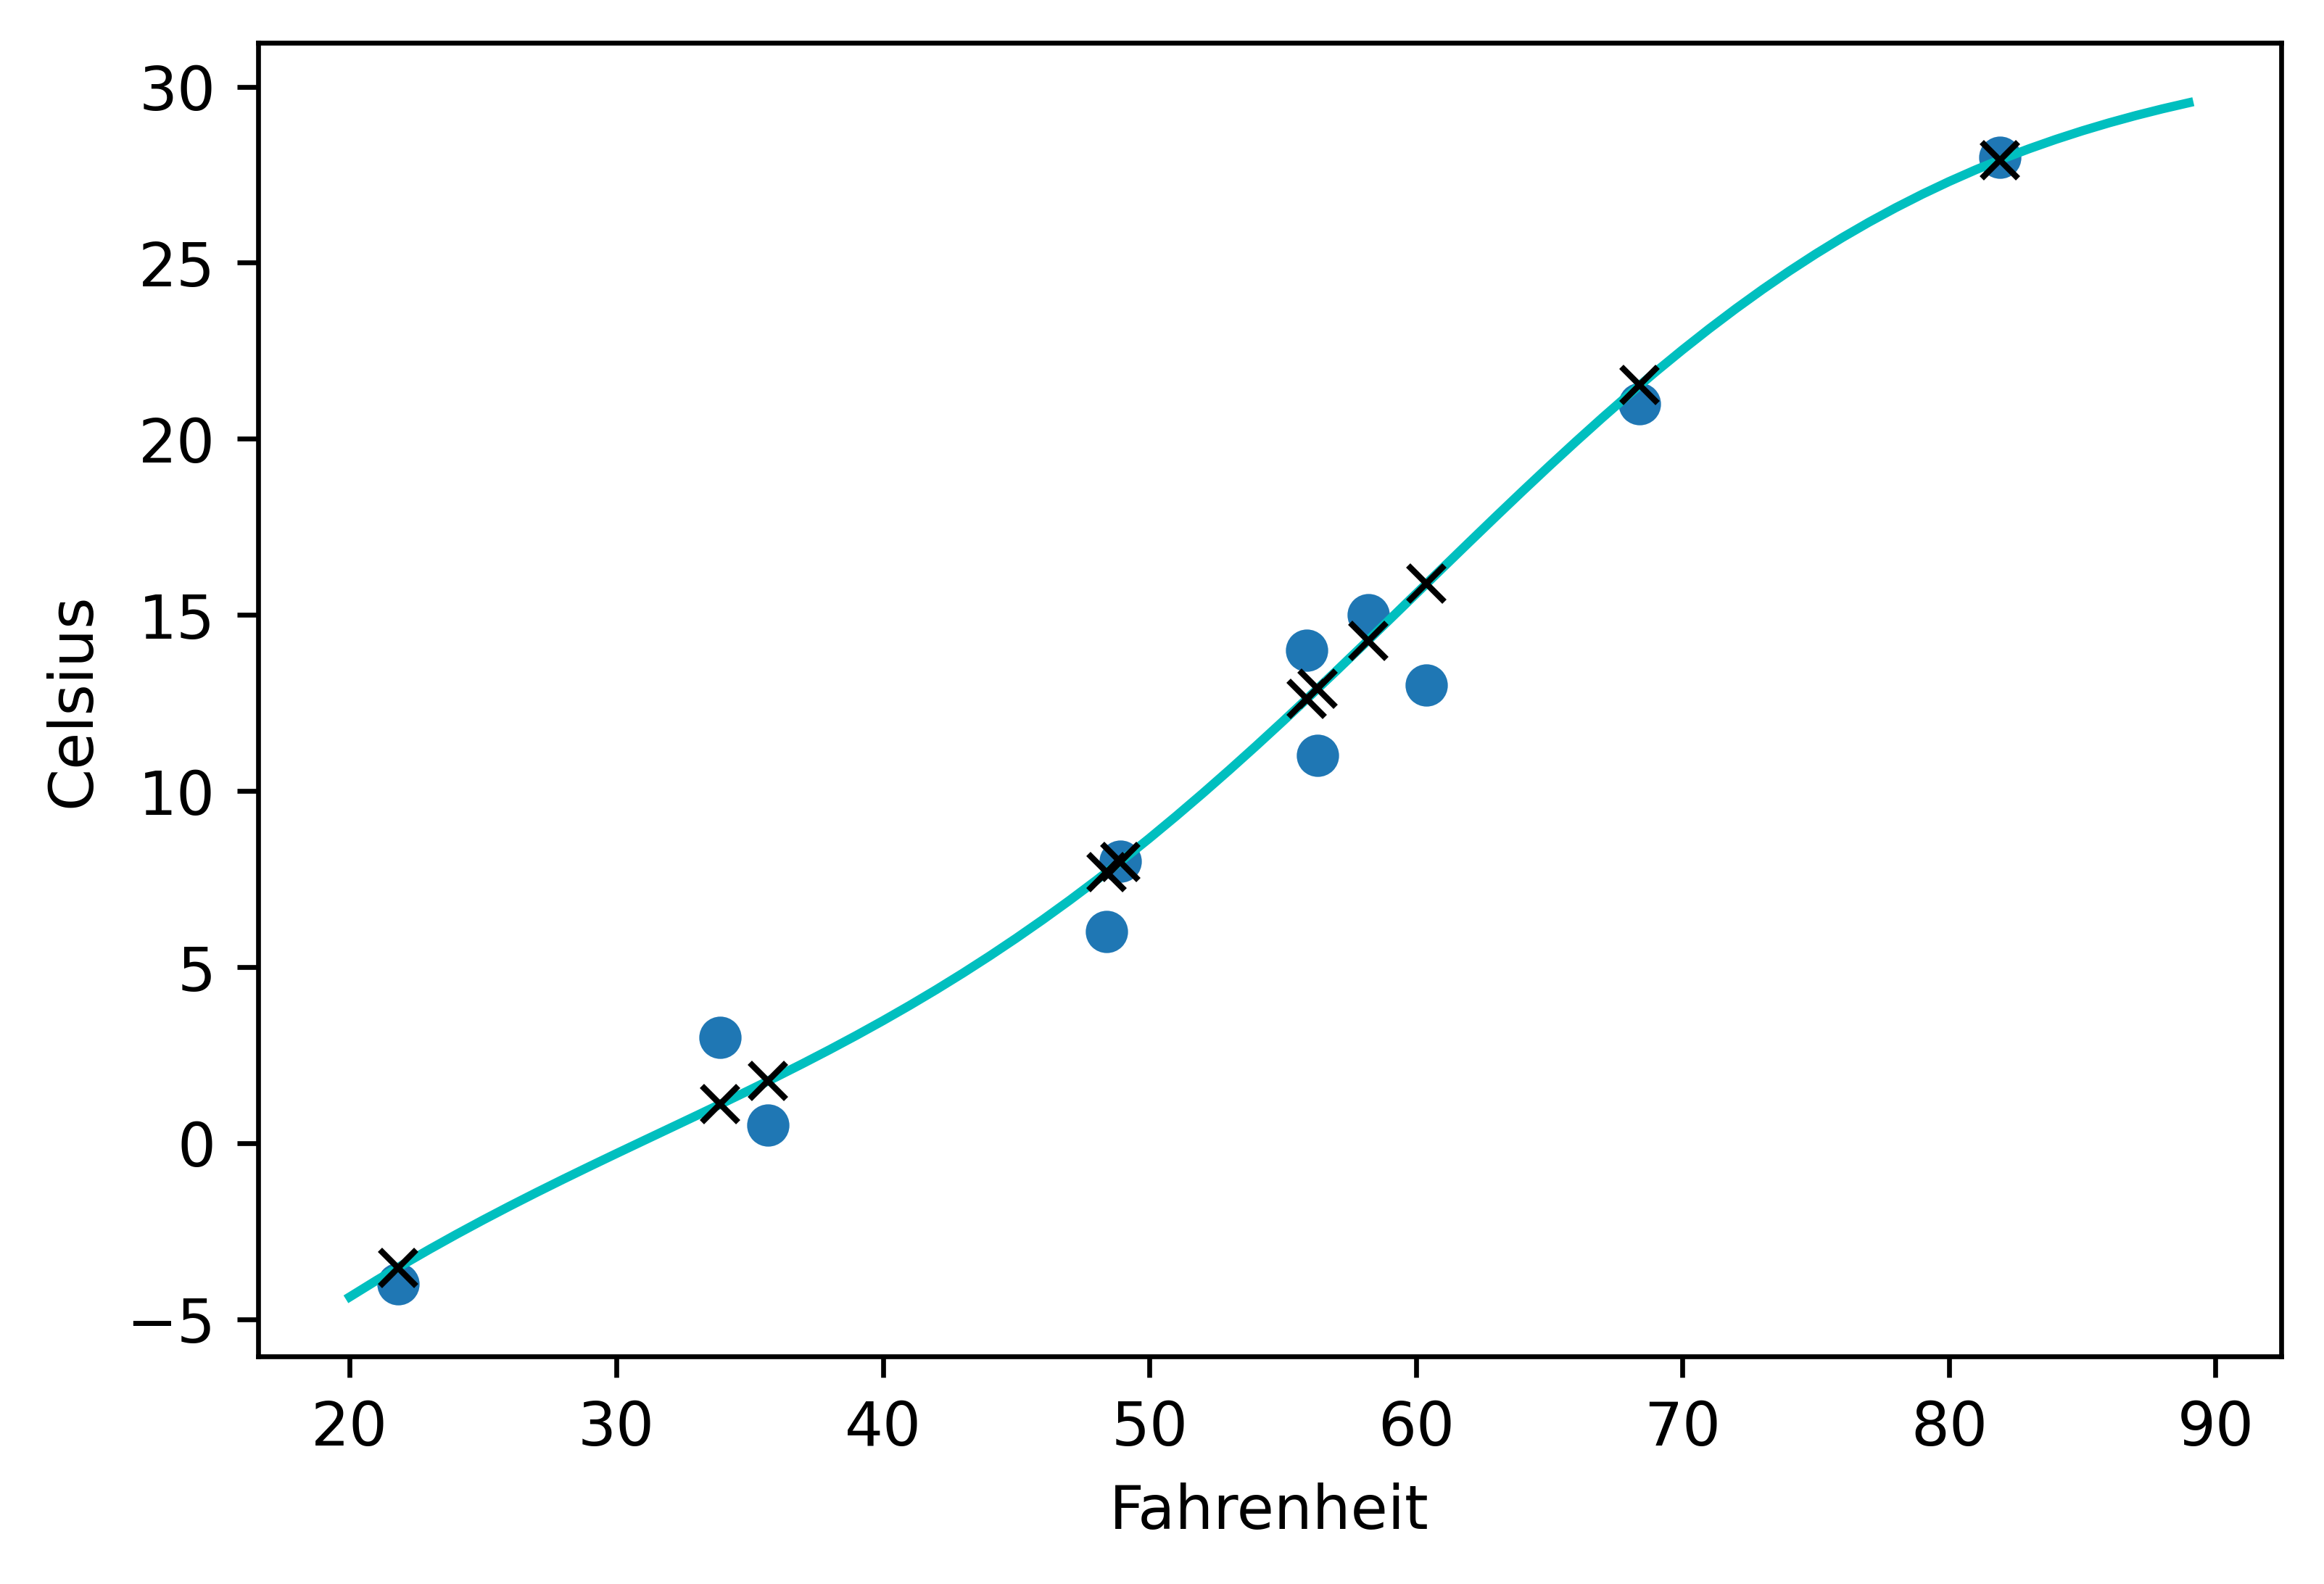

In [26]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

The result is shown in figure 6.9. We can appreciate that the neural network has a tendency
to overfit, as we discussed in chapter 5, since it tries to chase the measurements,
including the noisy ones. Even our tiny neural network has too many parameters to fit
the few measurements we have. It doesn’t do a bad job, though, overall.

## 6.4 Conclusion
We’ve covered a lot in chapters 5 and 6, although we have been dealing with a very
simple problem. We dissected building differentiable models and training them using
gradient descent, first using raw autograd and then relying on `nn`. By now you should
have confidence in your understanding of what’s going on behind the scenes. Hopefully
this taste of PyTorch has given you an appetite for more!

## 6.5 Exercises
1. Experiment with the number of hidden neurons in our simple neural network model, as well as the learning rate.
    * What changes result in more linear output from the model?
    * Can you get the model to obviously overfit the data?
2. The third-hardest problem in physics is finding a proper wine to celebrate discoveries. Load the wine data from chapter 4, and create a new model with the appropriate number of input parameters.
    * How long does it take to train compared to the temperature data we have been using?
    * Can you explain what factors contribute to the training times?
    * Can you get the loss to decrease while training on this dataset?
    * How would you go about graphing this dataset?

Epoch 1, Training loss 199.8845, Validation loss 85.8282
Epoch 1000, Training loss 62.6604, Validation loss 2.9686
Epoch 2000, Training loss 39.3192, Validation loss 4.4026
Epoch 3000, Training loss 21.2793, Validation loss 4.9533
Epoch 4000, Training loss 11.4672, Validation loss 5.1280
Epoch 5000, Training loss 7.4190, Validation loss 5.0025


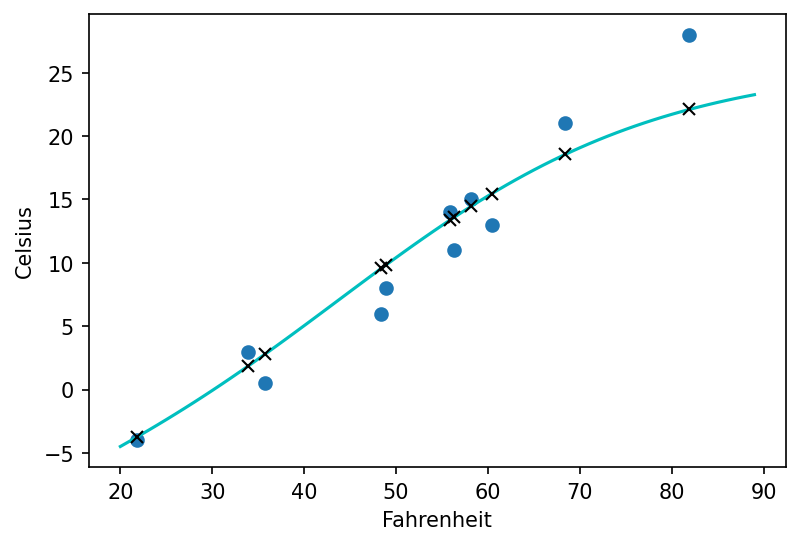

In [28]:
from torch import optim
neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

## 6.6 Summary
* Neural networks can be automatically adapted to specialize themselves on the problem at hand.
* Neural networks allow easy access to the analytical derivatives of the loss with respect to any parameter in the model, which makes evolving the parameters very efficient. Thanks to its automated differentiation engine, PyTorch provides such derivatives effortlessly.
* Activation functions around linear transformations make neural networks capable of approximating highly nonlinear functions, at the same time keeping them simple enough to optimize.
* The nn module together with the tensor standard library provide all the building blocks for creating neural networks.
* To recognize overfitting, it’s essential to maintain the training set of data points separate from the validation set. There’s no one recipe to combat overfitting, but getting more data, or more variability in the data, and resorting to simpler models are good starts.
* Anyone doing data science should be plotting data all the time.